In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling & preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             classification_report, confusion_matrix, roc_curve, auc)

import joblib


In [2]:
from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()
df.describe()
df['gender'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,proportion
gender,
Female,0.585910
Male,0.413894
Other,0.000196


In [5]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


<Axes: >

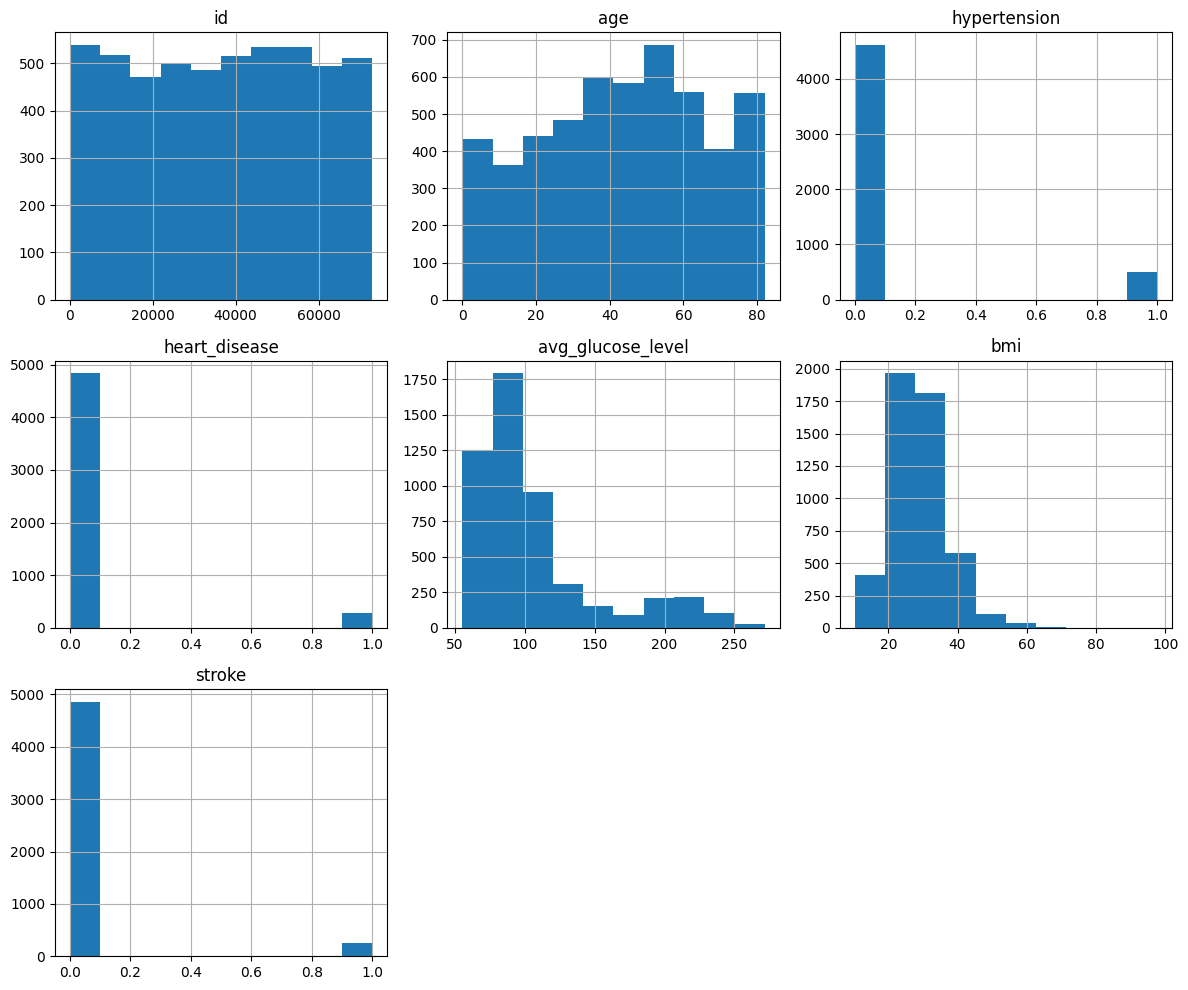

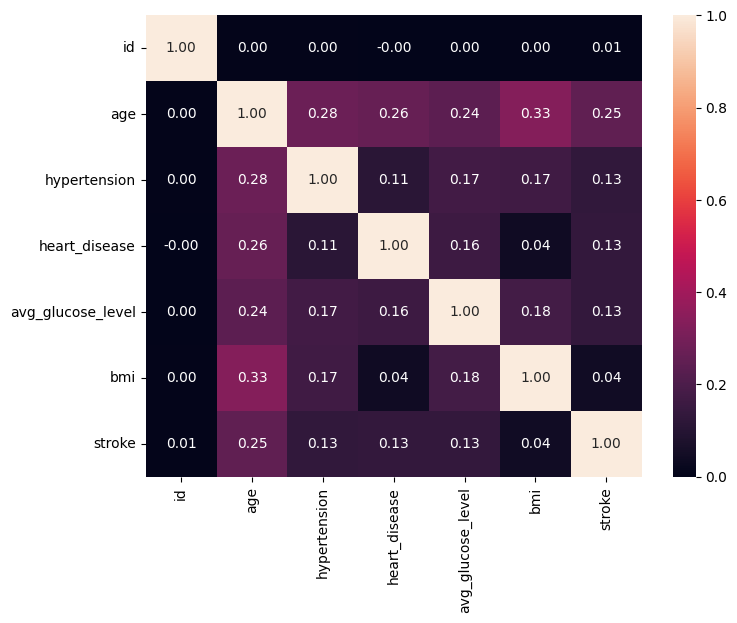

In [6]:
 # histogram for numerical cols
df.hist(figsize=(12,10))
plt.tight_layout()

import seaborn as sns
plt.figure(figsize=(8,6))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f")

In [8]:
# Define target variable 'y' and features 'X'
y = df['stroke']

# Select numerical features for preprocessing, excluding 'id' and 'stroke'
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_features_to_process = [col for col in numerical_cols if col not in ['id', 'stroke']]
X = df[numerical_features_to_process]

# Impute median and scale inside a pipeline for numerical features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_processed = pd.DataFrame(numeric_pipeline.fit_transform(X), columns=X.columns)

# Display head of processed numerical features for verification
print(X_processed.head())

        age  hypertension  heart_disease  avg_glucose_level       bmi
0  1.051434     -0.328602       4.185032           2.706375  1.005086
1  0.786070     -0.328602      -0.238947           2.121559 -0.098981
2  1.626390     -0.328602       4.185032          -0.005028  0.472536
3  0.255342     -0.328602      -0.238947           1.437358  0.719327
4  1.582163      3.043196      -0.238947           1.501184 -0.631531


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred))


Accuracy: 0.9510763209393346
ROC AUC: 0.8403292181069959
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
rf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators':[100,200], 'max_depth':[None,6,10]}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
best = grid.best_estimator_
y_pred_rf = best.predict(X_test)
print("Best params:", grid.best_params_)
print("RF ROC AUC:", roc_auc_score(y_test, best.predict_proba(X_test)[:,1]))


Best params: {'max_depth': 6, 'n_estimators': 100}
RF ROC AUC: 0.8380967078189301


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define target variable 'y' and features 'X'
X = df.drop('stroke', axis=1)
y = df['stroke']

# Identify numerical and categorical columns
# Exclude 'id' as it's just an identifier and 'stroke' is the target
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Impute missing numerical values (e.g., for bmi)
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values if any
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

# Apply the preprocessing to X
X_preprocessed_full = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding for categorical columns
# all_feature_names = numerical_cols + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))
# X_preprocessed_full = pd.DataFrame(X_preprocessed_full, columns=all_feature_names, index=X.index)

# Now split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_full, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
probs = lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, probs))


              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

ROC AUC: 0.8412962962962963


In [14]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
probs = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, probs))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

ROC AUC: 0.7829012345679012


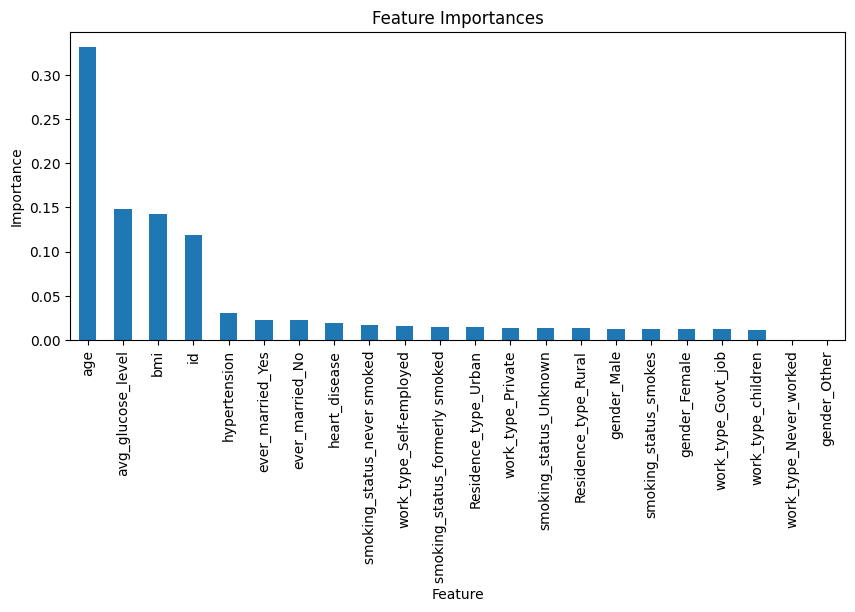

In [16]:
# Get the feature names after preprocessing
# Numerical features processed by 'num' pipeline (defined as numerical_cols in cell dH6PdOY8SaGg)
numerical_features_out = numerical_cols

# Categorical features processed by 'cat' pipeline (OneHotEncoder)
categorical_features_out = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

# Combine all feature names
all_feature_names = list(numerical_features_out) + list(categorical_features_out)

# Create the Series with correct index
importances = pd.Series(rf.feature_importances_, index=all_feature_names)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

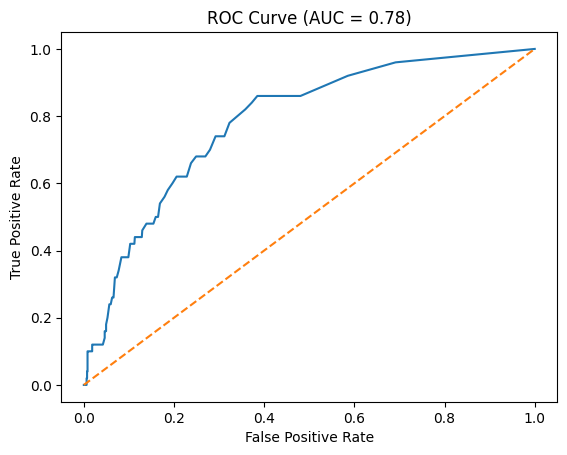

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [19]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs("models", exist_ok=True)

joblib.dump(rf, "models/stroke_rf.pkl")

['models/stroke_rf.pkl']

In [20]:
!zip -r project.zip /content


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.11.07/ (stored 0%)
  adding: content/.config/logs/2025.11.07/14.30.06.191154.log (deflated 58%)
  adding: content/.config/logs/2025.11.07/14.30.30.258639.log (deflated 56%)
  adding: content/.config/logs/2025.11.07/14.30.17.651067.log (deflated 86%)
  adding: content/.config/logs/2025

In [21]:
from google.colab import files
files.download("project.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>